# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Dmitry 3119
# student 2:

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:
# Libraries Im using
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np


In [3]:
# Load the data sets

train_data = pd.read_csv('titanic_train.csv')
test_data = pd.read_csv('titanic_test.csv')

# Sample of each data set
print("Training Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())


Training Data:
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0

Testing Data:
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1


In [4]:
#EDA
print(train_data.dtypes)

Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
Survived      int64
dtype: object


In [5]:
missing_values = train_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [6]:
# Find duplicate rows in the dataset
duplicate_rows = train_data[train_data.duplicated()]

# Count the number of duplicate rows
num_duplicates = duplicate_rows.shape[0]

# Output the results
print(f"Number of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print("Duplicate rows:")
    print(duplicate_rows)


Number of duplicate rows: 80
Duplicate rows:
     Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
46        3    1  29.699118      0      0   7.2500         0         0
74        3    0  29.699118      3      1  25.4667         0         0
94        3    0  29.699118      0      0   7.7500         2         1
142       2    1  34.000000      0      0  13.0000         0         0
150       3    1  20.000000      0      0   7.8542         0         0
..      ...  ...        ...    ...    ...      ...       ...       ...
697       3    1  25.000000      0      0   7.0500         0         0
700       3    0  29.699118      0      0   7.7500         2         1
704       2    1  23.000000      0      0  13.0000         0         0
706       3    1  29.699118      0      0   7.8958         0         0
710       2    1  29.699118      0      0   0.0000         0         0

[80 rows x 8 columns]


In [7]:
#Drop Duplicates
train_data = train_data.drop_duplicates()

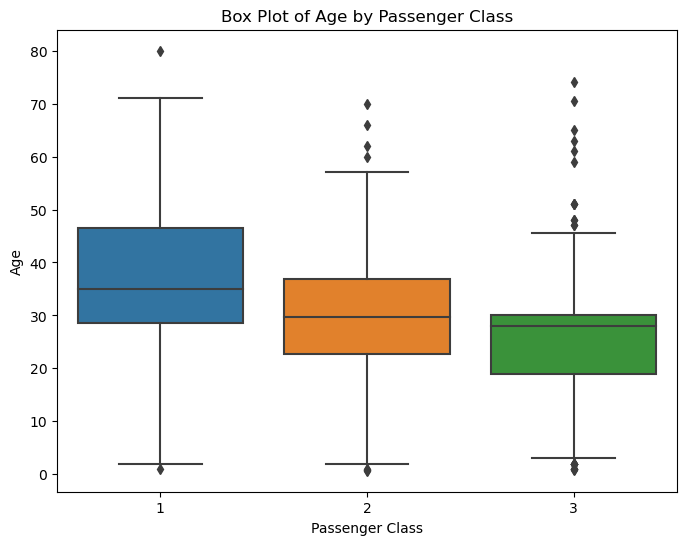

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Pclass', y='Age', data=train_data)
plt.title("Box Plot of Age by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.show()

# We can understand from here that 1st class passengers tend to be older with median age of 37
#The 1st class IQR appears to be the widest which makes the distrebution of ages higher than 2nd and 3rd class.
#The class 3 has the most potential for lots of outliers, a lot of ages are outisde of whisker.

Number of rows after removing outliers: 606


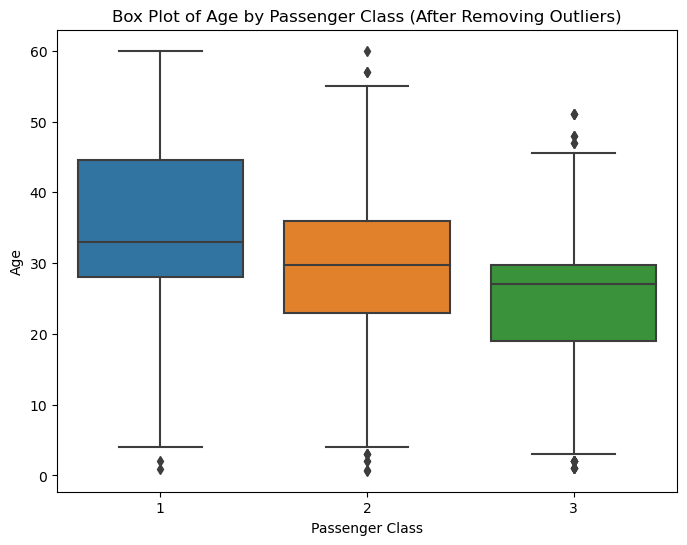

In [9]:
def remove_outliers_by_class(df, column, group_col):
    for pclass in df[group_col].unique():
        class_data = df[df[group_col] == pclass]
        Q1 = class_data[column].quantile(0.25)
        Q3 = class_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[~((df[group_col] == pclass) & ((df[column] < lower_bound) | (df[column] > upper_bound)))]
    
    return df

train_data = remove_outliers_by_class(train_data, 'Age', 'SibSp')
print(f"Number of rows after removing outliers: {train_data.shape[0]}")

# Plot the boxplot again to check
plt.figure(figsize=(8, 6))
sns.boxplot(x='Pclass', y='Age', data=train_data)
plt.title("Box Plot of Age by Passenger Class (After Removing Outliers)")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.show()

###The graph looks better after removing the outleirs.


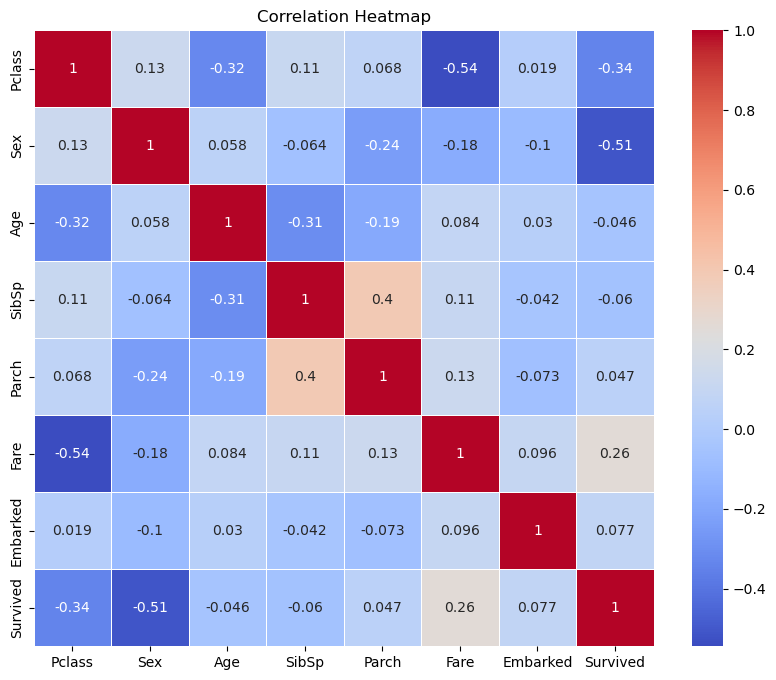

In [10]:
plt.figure(figsize=(10, 8))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()
#We can see a high correlation between Sibsp and Parch which is not a big surprise 
#Also we can logically see the -0.51 correlation between sex and survival rate which makes me think 
# the sex = 0 is female. If sex increses meaning goes from 0 to 1 we observe that survival rate decreases.

## Part 3 - Experiments
You could add as many code cells as needed

In [11]:
### Testing different models on the data sets 
X = train_data.drop(columns=['Survived'])  
y = train_data['Survived']                 
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
#Lets try with random forest classifier first
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split a node
}

# Perform Grid Search with 5-fold cross-validation
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
print(f"Best F1-Macro Score: {grid_search_rf.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best F1-Macro Score: 0.7602208656216222


In [13]:
# Lets try with Logistic Regression next
log_model = LogisticRegression(max_iter=200)
param_grid_log = {
    'C': [0.1, 1.0, 10.0],        # Regularization strength
    'solver': ['liblinear', 'lbfgs']  # Algorithm to use
}

# Perform Grid Search with 5-fold cross-validation
grid_search_log = GridSearchCV(log_model, param_grid_log, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_log.fit(X_train, y_train)

# Best parameters and score
print(f"Best Logistic Regression Parameters: {grid_search_log.best_params_}")
print(f"Best F1-Macro Score: {grid_search_log.best_score_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': 1.0, 'solver': 'liblinear'}
Best F1-Macro Score: 0.7766966333374109


In [14]:
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Calculate F1-macro score
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"Test F1-Macro Score (Random Forest): {f1_rf}")

Test F1-Macro Score (Random Forest): 0.7381131131131131


In [15]:
best_log_model = grid_search_log.best_estimator_
y_pred_log = best_log_model.predict(X_test)

# Calculate F1-macro score
f1_log = f1_score(y_test, y_pred_log, average='macro')
print(f"Test F1-Macro Score (Logistic Regression): {f1_log}")

Test F1-Macro Score (Logistic Regression): 0.7288977159880834


In [16]:
results = {
    'Model': ['Random Forest', 'Logistic Regression'],
    'Best Hyperparameters': [grid_search_rf.best_params_, grid_search_log.best_params_],
    'F1-Macro CV Score': [grid_search_rf.best_score_, grid_search_log.best_score_],
    'F1-Macro Test Score': [f1_rf, f1_log]
}

results_df = pd.DataFrame(results)
display(results_df)

#F1-Macro Cross Validation Score shows performance of the model on multiple subsets of the training data during the grid search.
#F1-Macro Test Score shows performance on unseen data set.
# We can see clearly that Random Forest is the best decision by now.

,Model,Best Hyperparameters,F1-Macro CV Score,F1-Macro Test Score
0,Random Forest,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.760221,0.738113
1,Logistic Regression,"{'C': 1.0, 'solver': 'liblinear'}",0.776697,0.728898


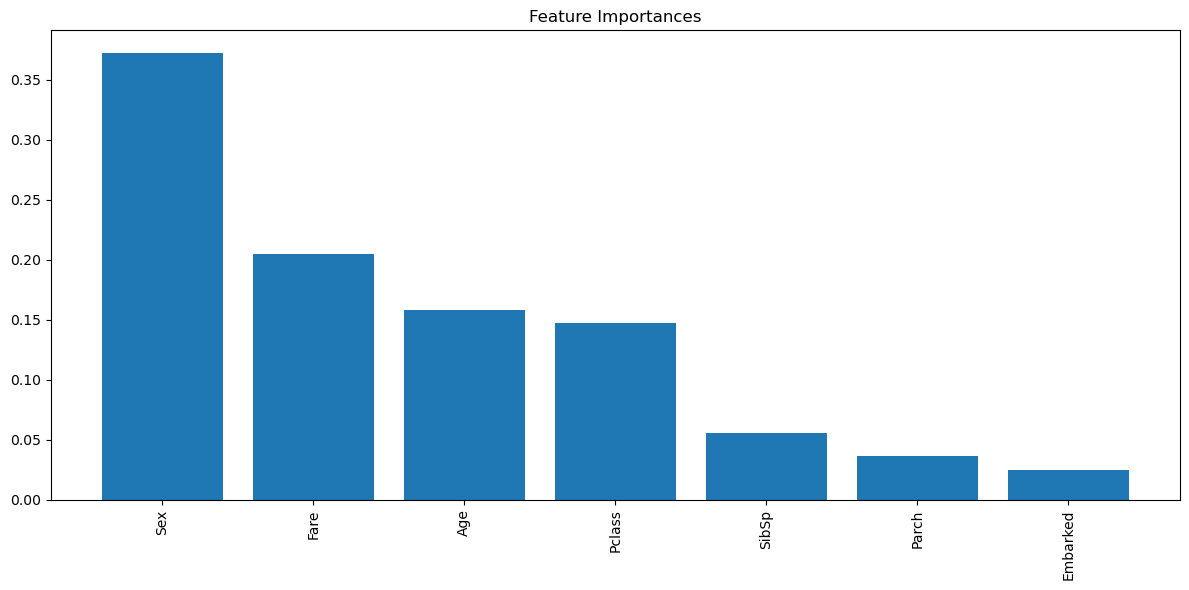

In [17]:
### From this point I choose to continue with rf model
importances = best_rf_model.feature_importances_

# Get the feature names
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()
# This graph gives me understanding of the contribution in each feature.

In [18]:
#Feature Engineering 

#Use Fare_ZScore using formula of Z_Score normalization = Z= (X−μ)/σ
#X = The actual fare value
#μ = mean Fare for that Pclass
#σ = standard deviation of the Fare within that Pclass

train_data['Fare_ZScore'] = train_data.groupby('Pclass')['Fare'].transform(lambda x: (x - x.mean()) / x.std())

#Remove the target and less isgnificant contributing features 
X = train_data.drop(columns=['Survived','Embarked','Parch'])
y = train_data['Survived']  # Target

# Split the data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Perform Grid Search with 5-fold cross-validation
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Extract the best parameters and score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Print the best parameters and score
print(f"Best Random Forest Parameters: {best_params_rf}")
print(f"Best F1-Macro CV Score: {best_score_rf}")

# Predict on the test set using the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Calculate F1-macro score on the test set
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"Test F1-Macro Score (Random Forest): {f1_rf}")

###Feature Engineering managed to improve F1-Macro Score by 0.03

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
Best F1-Macro CV Score: 0.7730193577940565
Test F1-Macro Score (Random Forest): 0.7505295950155764


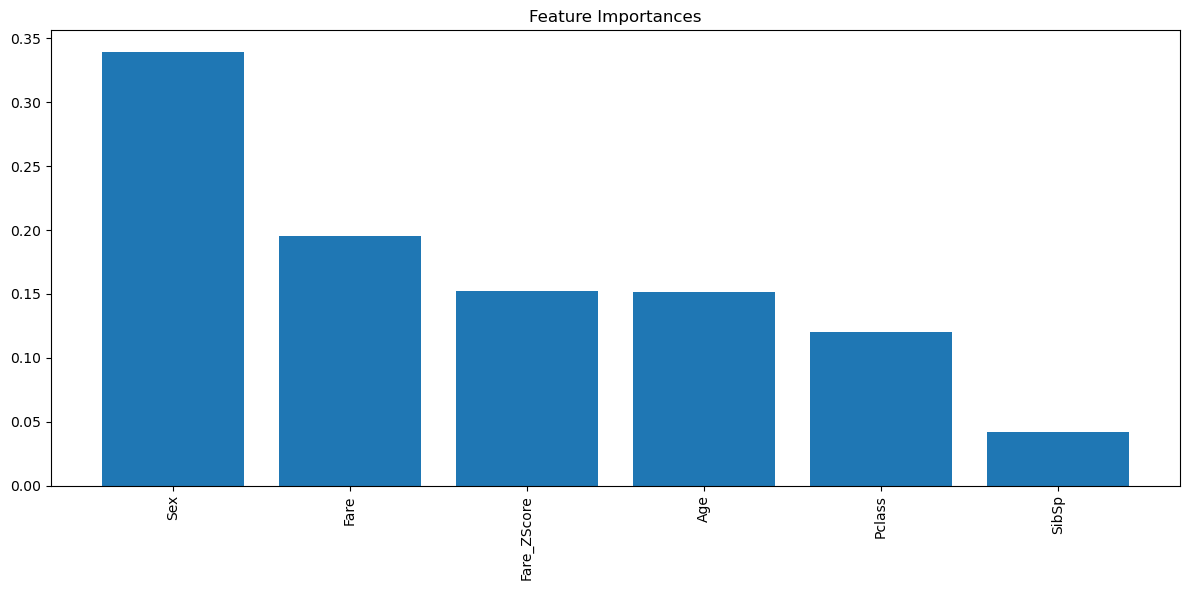

In [19]:
importances = best_rf_model.feature_importances_

# Get the feature names
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [20]:
X = train_data.drop(columns=['Survived'])  # Features
y = train_data['Survived']  # Target
#Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}

# Train the best Random Forest model on the entire dataset
best_rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10, random_state=42)
best_rf_model.fit(X, y)

# Perform 5-fold cross-validation and get the average F1-macro score
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='f1_macro')
print(f"Cross-validation F1-Macro score (5-fold): {cv_scores.mean():.4f}")

Cross-validation F1-Macro score (5-fold): 0.7884


## Part 5 - Apply on test and show model performance estimation

In [21]:
#Add same feature to testing data set
test_data['Fare_ZScore'] = test_data.groupby('Pclass')['Fare'].transform(lambda x: (x - x.mean()) / x.std())

# Remove the 'Survived' column from the test data
X_test = test_data.drop(columns=['Survived'])


# Use the best Random Forest model to predict the outcomes on the test set
y_test_pred = best_rf_model.predict(X_test)

# Show the first 5 predictions
print("First 5 predictions on the test set:")
print(y_test_pred[:5])


First 5 predictions on the test set:
[0 0 0 1 0]


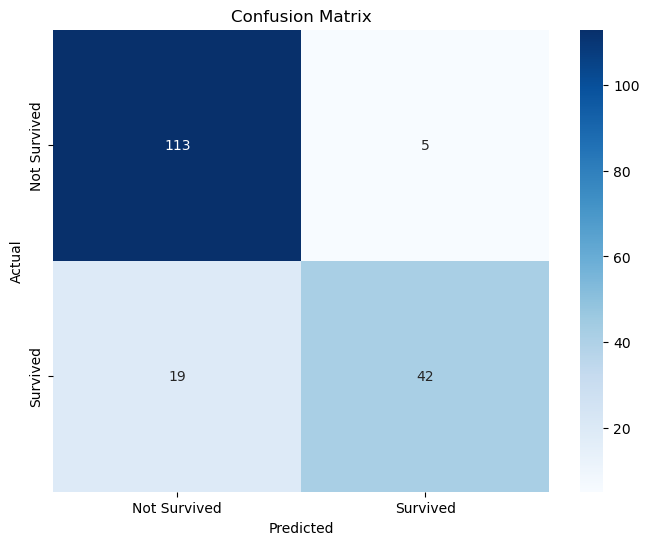

Accuracy Score: 0.8659


In [22]:
y_test_true = test_data['Survived']

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

# Plot the confusion matrix using seaborn's heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not Survived', 'Survived'], 
            yticklabels=['Not Survived', 'Survived'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Accuracy Score: {accuracy:.4f}")

In [23]:
### Accuracy Score : 86.59%